In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models

import os
import random

In [26]:
def get_data(tensorString, label_list):
    label = tf.strings.split(tensorString, os.path.sep)[-2]
    label = label==label_list
    label = tf.cast(label, tf.int32)
    label = tf.expand_dims(label, axis=0)
    label = tf.expand_dims(label, axis=0)
    img = tf.io.read_file(tensorString)
    img = tf.io.decode_png(img, channels=3)
    return img, label

def read_pic(path):
    pic = tf.io.read_file(path)
    pic = tf.io.decode_png(pic, channels=3)
    pic = tf.image.resize(pic, (720,720))
    return pic

def printArray(a):
    for row in range(8):
        for col in range(8):
            space = (9-len(a[row, col]))
            print(a[row, col], end=' '*space)
        print('\n'*2)
        
def shuffleImage(im):
    M = im.shape[0]//8
    N = im.shape[1]//8
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
    random.shuffle(tiles)
    tiles = [tiles[i:i+8] for i in range(0, len(tiles), 8)]
    tiles = np.asarray(tiles)
    strip = np.concatenate(tiles[0])
    for i in range(1,8):
        strip = np.concatenate((strip, np.concatenate(tiles[i])), axis=1)

    return strip

In [27]:
label2num = {
     b'empty': 0,
     b'bBishop': 1,
     b'bKing': 2,
     b'bKnight': 3,
     b'bPawn': 4,
     b'bQueen': 5,
     b'bRook': 6,
     b'wBishop': 7,
     b'wKing': 8,
     b'wKnight': 9,
     b'wPawn': 10,
     b'wQueen': 11,
     b'wRook': 12
}

num2label = {y: x for x, y in label2num.items()}


In [28]:
train_ds = tf.data.Dataset.list_files('DATA/train/*/*.png', shuffle=False)
train_ds = train_ds.shuffle(buffer_size=len(train_ds), seed=123, reshuffle_each_iteration=False)
train_ds = train_ds.map(lambda x:get_data(x, list(label2num.keys()))).batch(len(train_ds))

In [29]:
for i in train_ds.take(1):
    print(i)

(<tf.Tensor: shape=(44, 90, 90, 3), dtype=uint8, numpy=
array([[[[ 55,  54,  47],
         [124, 156,  93],
         [123, 154,  92],
         ...,
         [123, 154,  92],
         [123, 154,  92],
         [121, 153,  89]],

        [[ 54,  54,  46],
         [117, 150,  85],
         [116, 148,  84],
         ...,
         [116, 148,  84],
         [116, 148,  84],
         [114, 146,  82]],

        [[ 54,  54,  46],
         [119, 152,  87],
         [118, 150,  86],
         ...,
         [118, 150,  86],
         [118, 150,  86],
         [115, 148,  83]],

        ...,

        [[ 54,  54,  46],
         [119, 152,  87],
         [118, 150,  86],
         ...,
         [118, 150,  86],
         [118, 150,  86],
         [115, 148,  83]],

        [[ 54,  54,  46],
         [117, 150,  85],
         [116, 148,  84],
         ...,
         [116, 148,  84],
         [116, 148,  84],
         [114, 146,  82]],

        [[ 55,  54,  47],
         [124, 156,  93],
         [123, 154

In [30]:
tf.keras.backend.clear_session()
def get_model():
    model = models.Sequential([
        layers.InputLayer((None,None,3)),
        layers.Conv2D(8, (3,3), padding='same', activation='relu'),
        layers.Conv2D(16, (3,3), padding='same', activation='relu'),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.Conv2D(64, (3,3), strides=5, padding='same', activation='relu'),
        layers.Conv2D(128, (3,3), strides=3, padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), strides=3, padding='same', activation='relu'),
        layers.Conv2D(13, (2,2), strides=2, activation='softmax')
    ])
    
    model.summary()
    model.compile(optimizer=optimizers.Adam(0.001), loss=losses.CategoricalCrossentropy())
    return model
model = get_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 8)     224       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    4640      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 256)   295168    
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 13)    1

In [31]:
es = tf.keras.callbacks.EarlyStopping('loss', patience=50, restore_best_weights=True)
model.fit(train_ds, epochs=500, callbacks=[es])

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 16.4938
Epoch 2/500
1/1 [==============================] - 0s 46ms/step - loss: 9.2729
Epoch 3/500
1/1 [==============================] - 0s 43ms/step - loss: 10.0744
Epoch 4/500
1/1 [==============================] - 0s 46ms/step - loss: 6.9935
Epoch 5/500
1/1 [==============================] - 0s 47ms/step - loss: 5.2700
Epoch 6/500
1/1 [==============================] - 0s 45ms/step - loss: 4.4951
Epoch 7/500
1/1 [==============================] - 0s 45ms/step - loss: 3.4623
Epoch 8/500
1/1 [==============================] - 0s 51ms/step - loss: 2.7472
Epoch 9/500
1/1 [==============================] - 0s 45ms/step - loss: 2.0832
Epoch 10/500
1/1 [==============================] - 0s 49ms/step - loss: 1.7259
Epoch 11/500
1/1 [==============================] - 0s 46ms/step - loss: 1.6765
Epoch 12/500
1/1 [==============================] - 0s 45ms/step - loss: 1.4896
Epoch 13/500
1/1 [==============================]

1/1 [==============================] - 0s 55ms/step - loss: 4.8171e-06
Epoch 101/500
1/1 [==============================] - 0s 55ms/step - loss: 4.7873e-06
Epoch 102/500
1/1 [==============================] - 0s 49ms/step - loss: 4.7493e-06
Epoch 103/500
1/1 [==============================] - 0s 60ms/step - loss: 4.7195e-06
Epoch 104/500
1/1 [==============================] - 0s 57ms/step - loss: 4.6925e-06
Epoch 105/500
1/1 [==============================] - 0s 60ms/step - loss: 4.6654e-06
Epoch 106/500
1/1 [==============================] - 0s 55ms/step - loss: 4.6356e-06
Epoch 107/500
1/1 [==============================] - 0s 50ms/step - loss: 4.6003e-06
Epoch 108/500
1/1 [==============================] - 0s 55ms/step - loss: 4.5787e-06
Epoch 109/500
1/1 [==============================] - 0s 58ms/step - loss: 4.5407e-06
Epoch 110/500
1/1 [==============================] - 0s 49ms/step - loss: 4.5218e-06
Epoch 111/500
1/1 [==============================] - 0s 51ms/step - loss: 4.494

1/1 [==============================] - 0s 52ms/step - loss: 3.1130e-06
Epoch 197/500
1/1 [==============================] - 0s 52ms/step - loss: 3.1048e-06
Epoch 198/500
1/1 [==============================] - 0s 49ms/step - loss: 3.0859e-06
Epoch 199/500
1/1 [==============================] - 0s 52ms/step - loss: 3.0805e-06
Epoch 200/500
1/1 [==============================] - 0s 54ms/step - loss: 3.0669e-06
Epoch 201/500
1/1 [==============================] - 0s 50ms/step - loss: 3.0561e-06
Epoch 202/500
1/1 [==============================] - 0s 53ms/step - loss: 3.0452e-06
Epoch 203/500
1/1 [==============================] - 0s 52ms/step - loss: 3.0290e-06
Epoch 204/500
1/1 [==============================] - 0s 55ms/step - loss: 3.0181e-06
Epoch 205/500
1/1 [==============================] - 0s 53ms/step - loss: 3.0073e-06
Epoch 206/500
1/1 [==============================] - 0s 53ms/step - loss: 2.9992e-06
Epoch 207/500
1/1 [==============================] - 0s 54ms/step - loss: 2.991

1/1 [==============================] - 0s 53ms/step - loss: 2.2081e-06
Epoch 293/500
1/1 [==============================] - 0s 58ms/step - loss: 2.2027e-06
Epoch 294/500
1/1 [==============================] - 0s 56ms/step - loss: 2.1918e-06
Epoch 295/500
1/1 [==============================] - 0s 54ms/step - loss: 2.1837e-06
Epoch 296/500
1/1 [==============================] - 0s 59ms/step - loss: 2.1674e-06
Epoch 297/500
1/1 [==============================] - 0s 52ms/step - loss: 2.1674e-06
Epoch 298/500
1/1 [==============================] - 0s 56ms/step - loss: 2.1566e-06
Epoch 299/500
1/1 [==============================] - 0s 48ms/step - loss: 2.1485e-06
Epoch 300/500
1/1 [==============================] - 0s 53ms/step - loss: 2.1430e-06
Epoch 301/500
1/1 [==============================] - 0s 48ms/step - loss: 2.1322e-06
Epoch 302/500
1/1 [==============================] - 0s 46ms/step - loss: 2.1268e-06
Epoch 303/500
1/1 [==============================] - 0s 48ms/step - loss: 2.116

1/1 [==============================] - 0s 44ms/step - loss: 1.5849e-06
Epoch 389/500
1/1 [==============================] - 0s 47ms/step - loss: 1.5741e-06
Epoch 390/500
1/1 [==============================] - 0s 46ms/step - loss: 1.5741e-06
Epoch 391/500
1/1 [==============================] - 0s 52ms/step - loss: 1.5714e-06
Epoch 392/500
1/1 [==============================] - 0s 42ms/step - loss: 1.5714e-06
Epoch 393/500
1/1 [==============================] - 0s 46ms/step - loss: 1.5633e-06
Epoch 394/500
1/1 [==============================] - 0s 51ms/step - loss: 1.5606e-06
Epoch 395/500
1/1 [==============================] - 0s 50ms/step - loss: 1.5551e-06
Epoch 396/500
1/1 [==============================] - 0s 46ms/step - loss: 1.5497e-06
Epoch 397/500
1/1 [==============================] - 0s 46ms/step - loss: 1.5497e-06
Epoch 398/500
1/1 [==============================] - 0s 49ms/step - loss: 1.5443e-06
Epoch 399/500
1/1 [==============================] - 0s 49ms/step - loss: 1.538

1/1 [==============================] - 0s 50ms/step - loss: 1.1840e-06
Epoch 485/500
1/1 [==============================] - 0s 57ms/step - loss: 1.1785e-06
Epoch 486/500
1/1 [==============================] - 0s 54ms/step - loss: 1.1758e-06
Epoch 487/500
1/1 [==============================] - 0s 52ms/step - loss: 1.1758e-06
Epoch 488/500
1/1 [==============================] - 0s 48ms/step - loss: 1.1704e-06
Epoch 489/500
1/1 [==============================] - 0s 54ms/step - loss: 1.1677e-06
Epoch 490/500
1/1 [==============================] - 0s 49ms/step - loss: 1.1623e-06
Epoch 491/500
1/1 [==============================] - 0s 47ms/step - loss: 1.1569e-06
Epoch 492/500
1/1 [==============================] - 0s 54ms/step - loss: 1.1542e-06
Epoch 493/500
1/1 [==============================] - 0s 46ms/step - loss: 1.1487e-06
Epoch 494/500
1/1 [==============================] - 0s 56ms/step - loss: 1.1460e-06
Epoch 495/500
1/1 [==============================] - 0s 52ms/step - loss: 1.143

In [32]:
model.predict(i[0])

2/2 [==============================] - 1s 118ms/step


array([[[[2.64341543e-06, 3.16861239e-08, 2.84904900e-09,
          1.45886254e-08, 9.99992728e-01, 1.39050398e-08,
          2.31588615e-08, 3.05560555e-08, 3.45439653e-14,
          1.62558944e-08, 4.50708512e-06, 1.05247955e-09,
          8.42115000e-09]]],


       [[[9.68883285e-09, 1.80015866e-06, 5.79051918e-10,
          5.12610427e-07, 2.64110263e-08, 9.99997735e-01,
          3.07185424e-08, 1.75502257e-09, 9.27040185e-16,
          1.17387081e-11, 1.02052073e-11, 1.02658104e-10,
          7.69076122e-11]]],


       [[[1.05983241e-27, 3.43316668e-21, 2.51370034e-24,
          1.00000000e+00, 2.10436928e-28, 8.69119771e-24,
          2.05862176e-18, 7.04112736e-35, 0.00000000e+00,
          9.70221659e-37, 2.25175255e-33, 3.33485308e-32,
          2.94124367e-34]]],


       [[[2.82120328e-21, 8.29160728e-19, 9.35583101e-23,
          1.10942472e-19, 1.00000000e+00, 2.45503169e-23,
          7.29231830e-20, 4.09201195e-26, 0.00000000e+00,
          5.47663024e-28, 6.21677101e

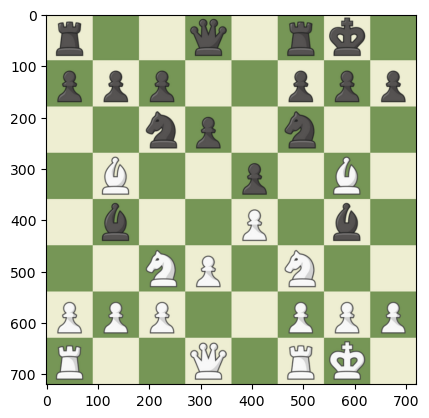

In [40]:
test_image = tf.cast(read_pic('DATA/raw/mid1.png'), tf.int32)
#test_image = shuffleImage(test_image)
plt.imshow(test_image)
plt.show()

In [41]:
pred = np.squeeze(np.argmax(model.predict(tf.expand_dims(test_image, axis=0)), axis=-1))
pred = np.vectorize(num2label.get)(pred)

1/1 [==============================] - 0s 29ms/step


In [42]:
printArray(pred)

b'bRook'    b'empty'    b'empty'    b'bQueen'   b'empty'    b'bRook'    b'bKing'    b'empty'    


b'bPawn'    b'bPawn'    b'bPawn'    b'empty'    b'empty'    b'bPawn'    b'bPawn'    b'bPawn'    


b'empty'    b'empty'    b'bKnight'  b'bPawn'    b'empty'    b'bKnight'  b'empty'    b'empty'    


b'empty'    b'wBishop'  b'empty'    b'empty'    b'bPawn'    b'empty'    b'wBishop'  b'empty'    


b'empty'    b'bBishop'  b'empty'    b'empty'    b'wPawn'    b'empty'    b'bBishop'  b'empty'    


b'empty'    b'empty'    b'wKnight'  b'wPawn'    b'empty'    b'wKnight'  b'empty'    b'empty'    


b'wPawn'    b'wPawn'    b'wPawn'    b'empty'    b'empty'    b'wPawn'    b'wPawn'    b'wPawn'    


b'wRook'    b'empty'    b'empty'    b'wQueen'   b'empty'    b'wRook'    b'wKing'    b'empty'    


